cat
activation map:


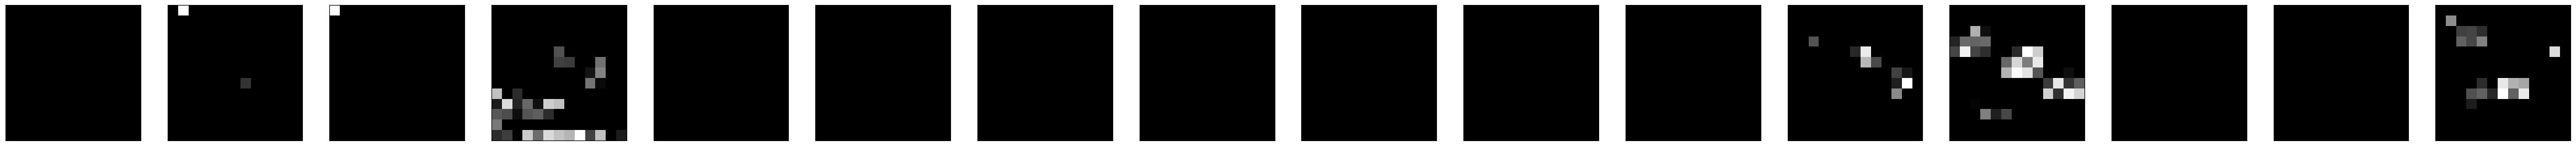

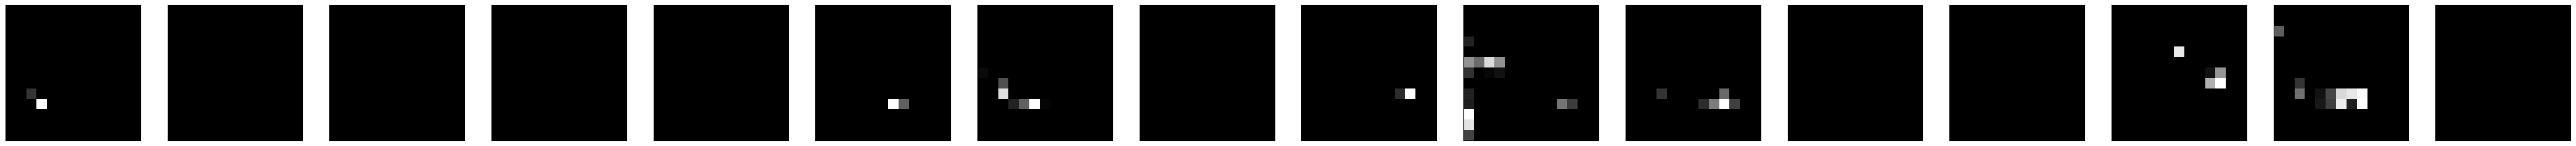

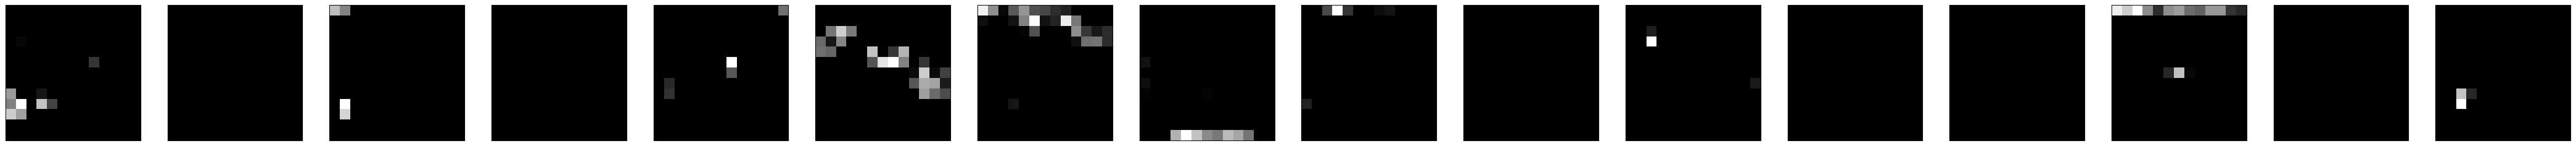

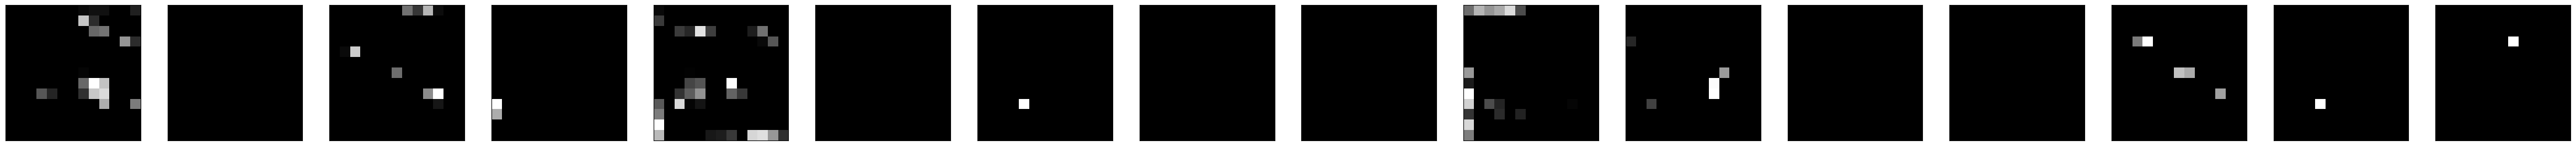

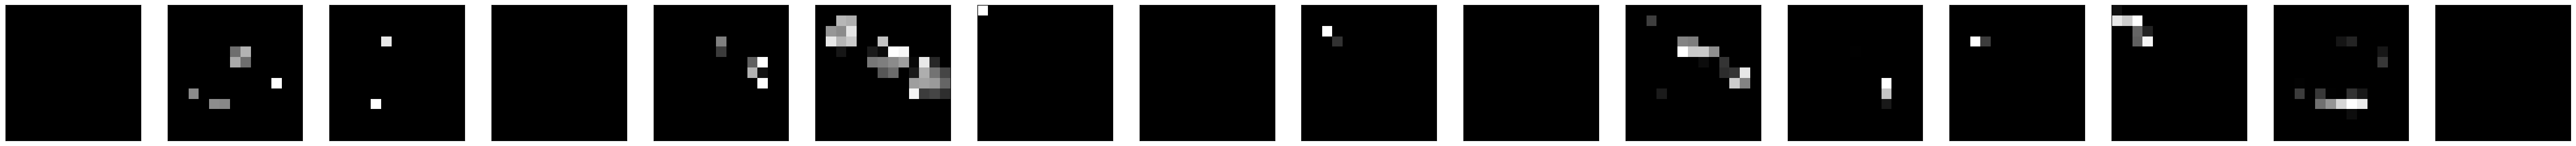

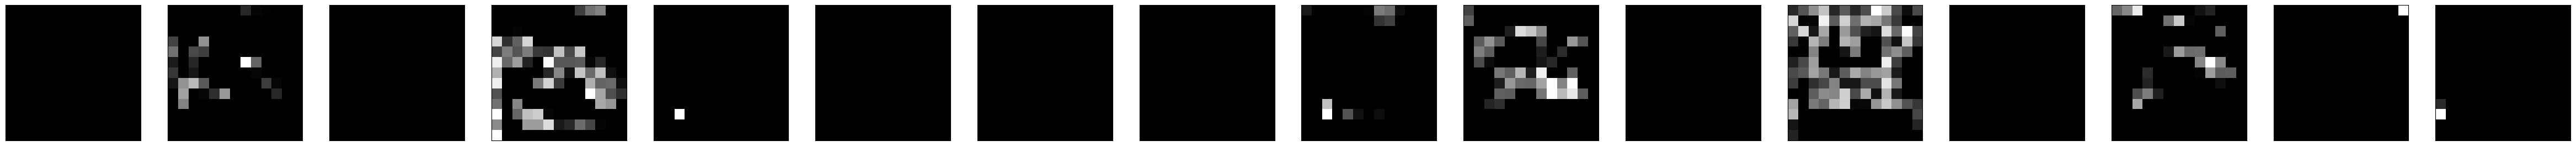

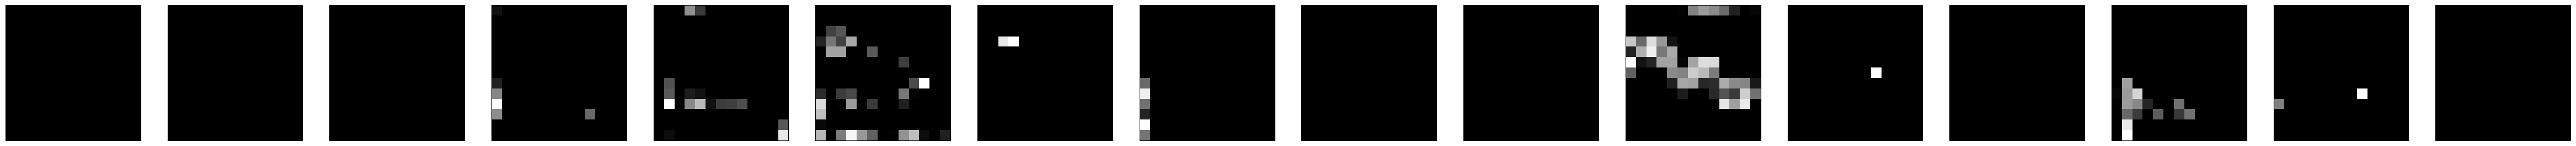

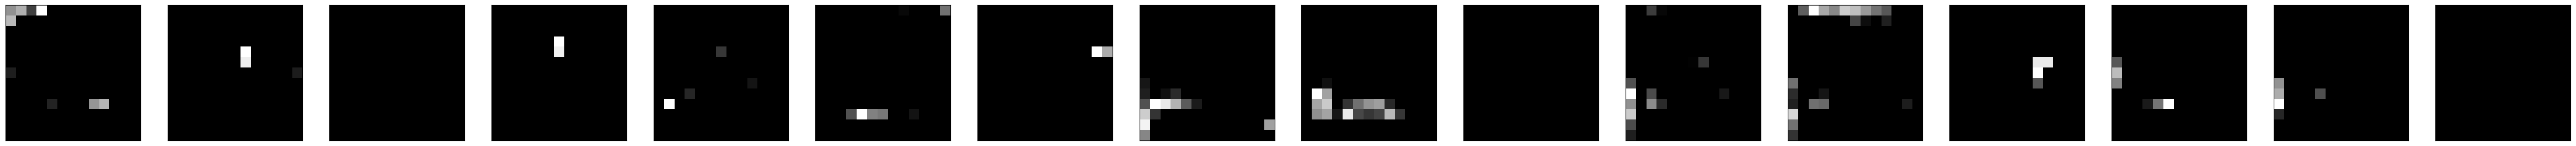

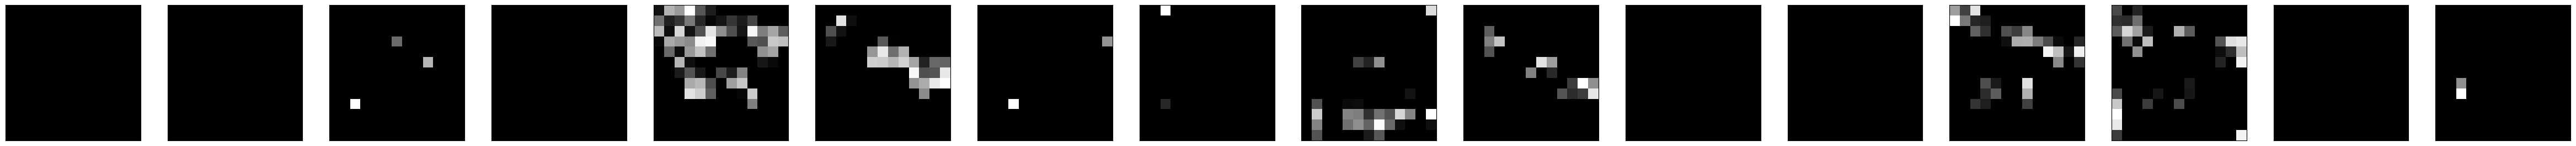

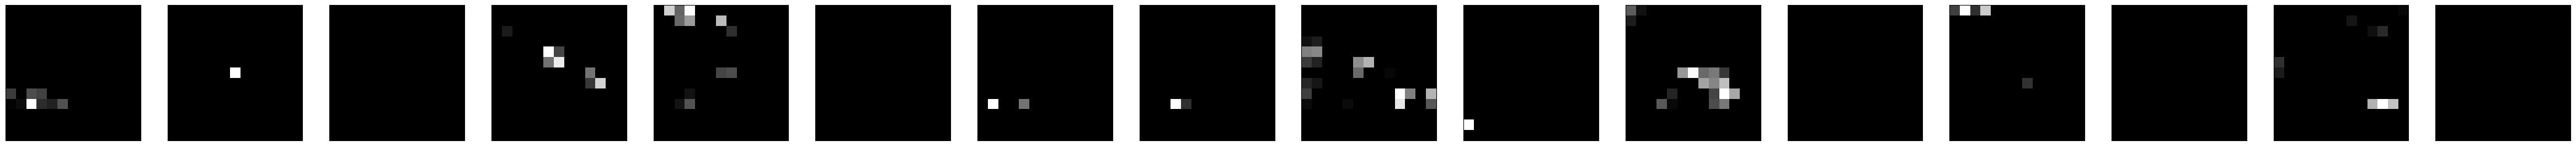

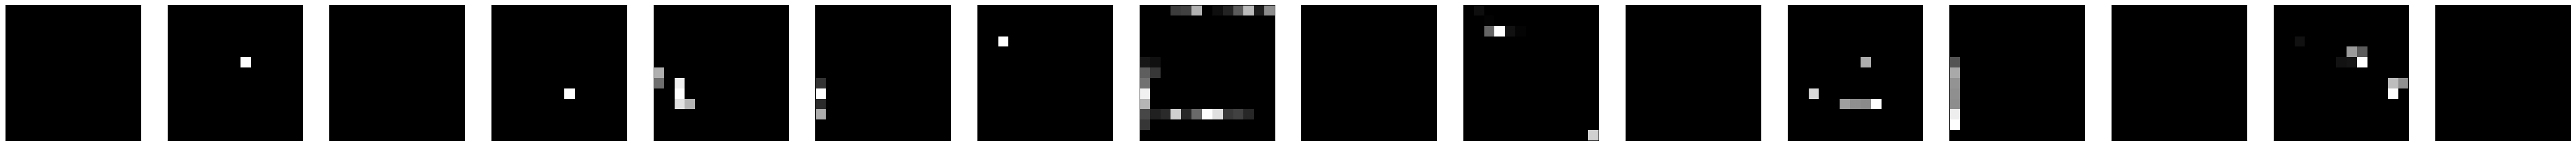

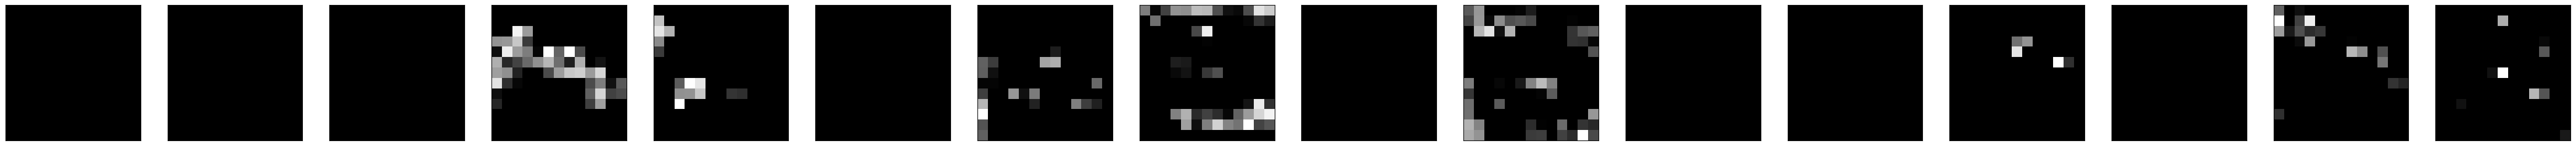

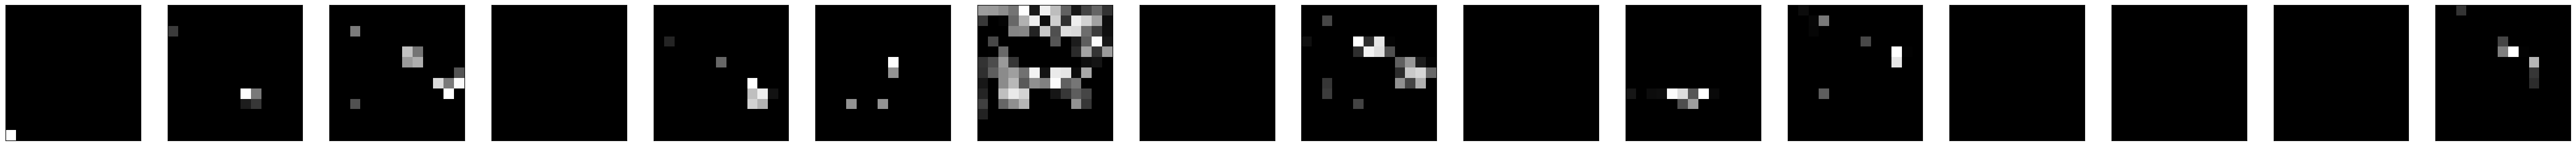

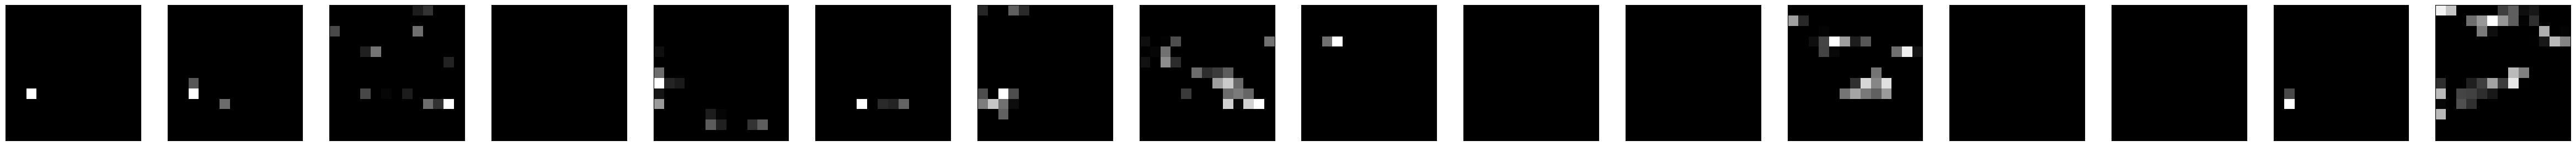

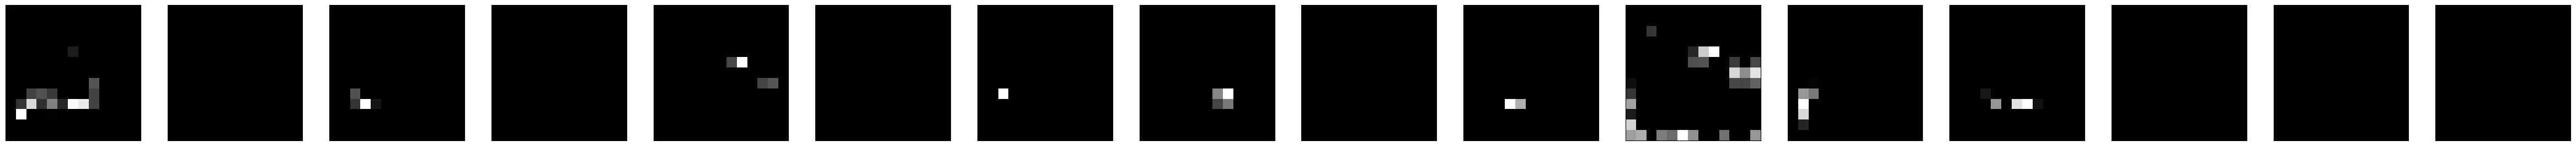

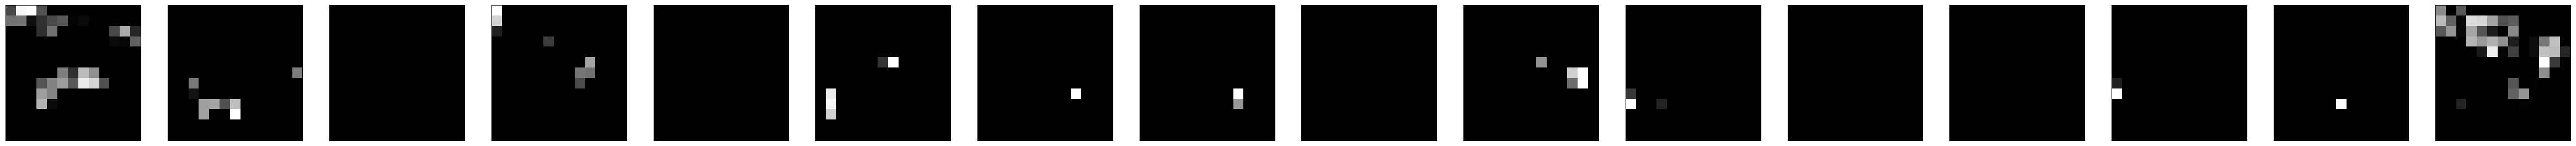

cam:


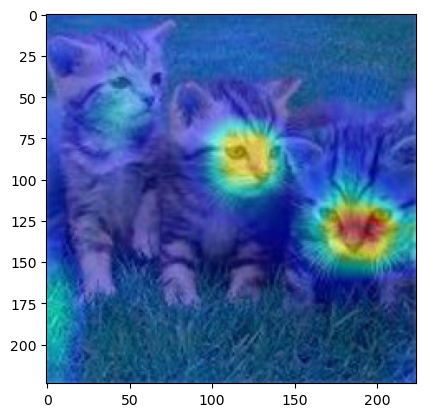

dog
activation map:


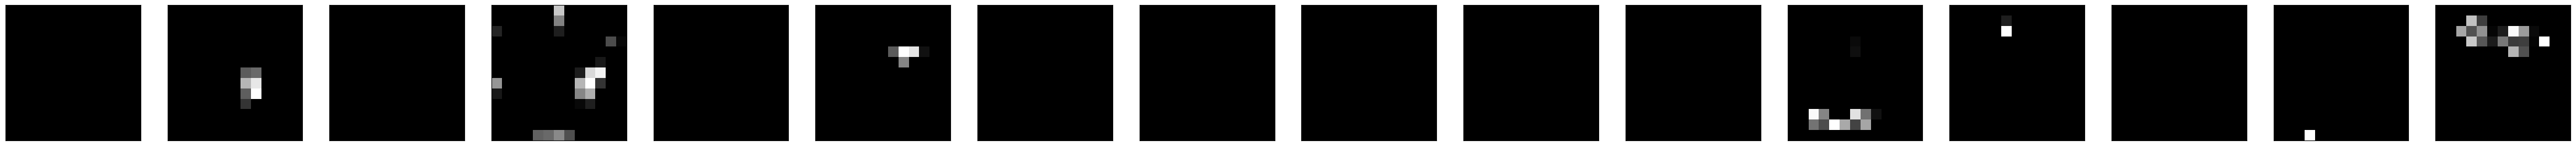

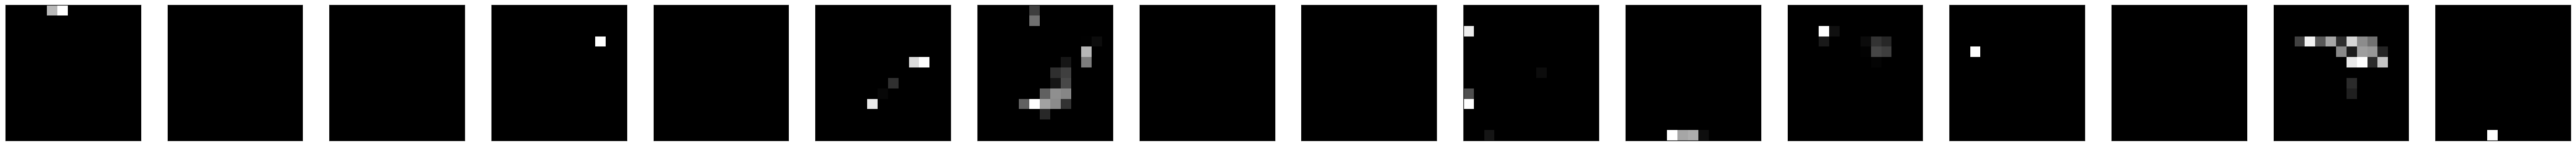

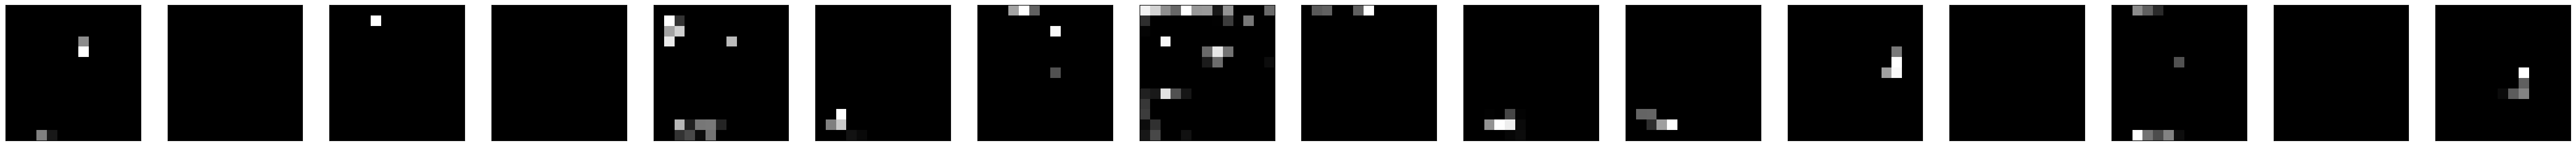

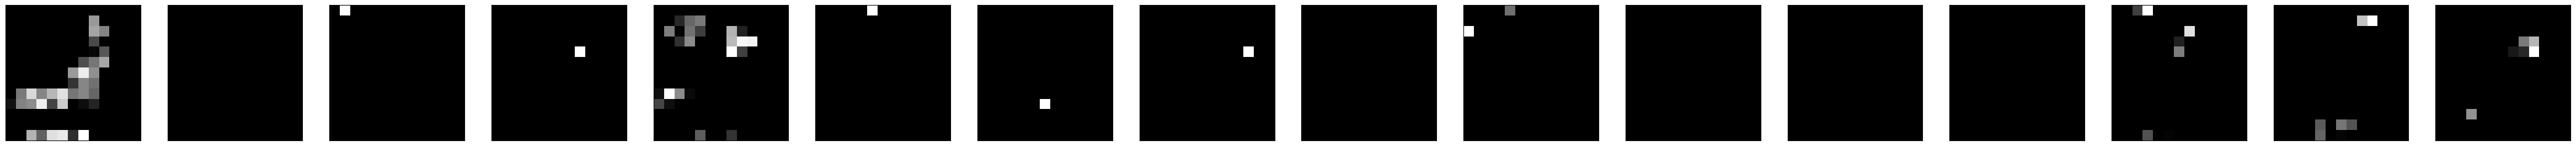

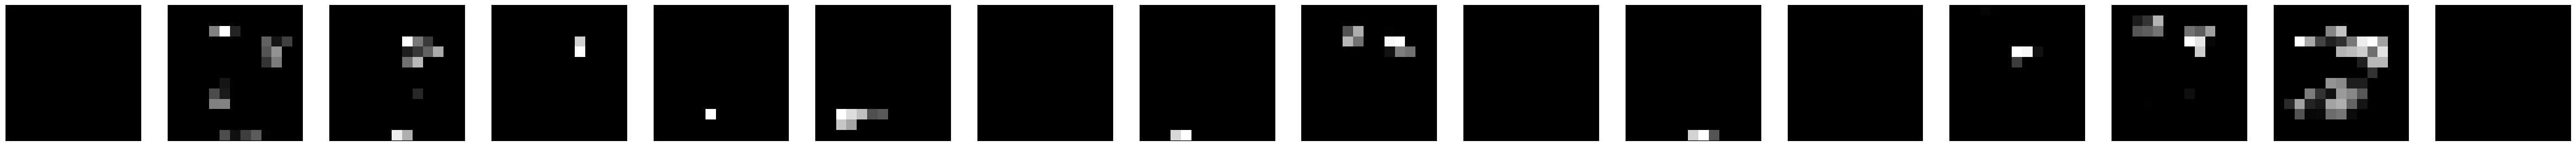

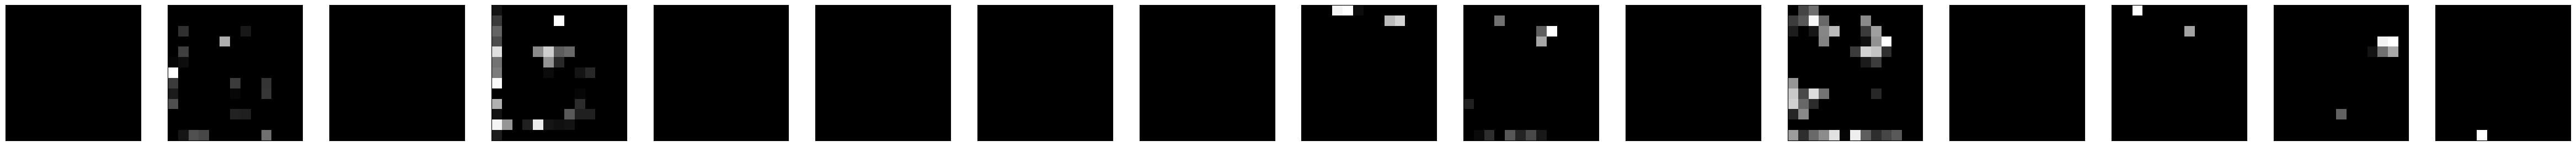

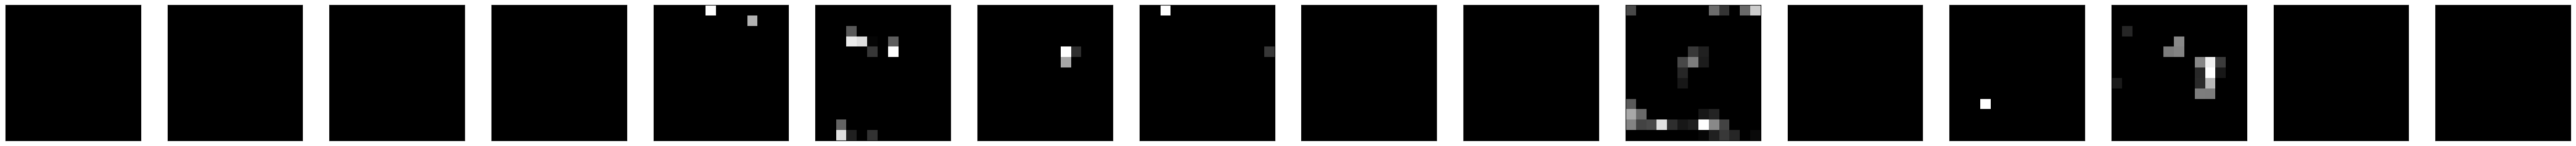

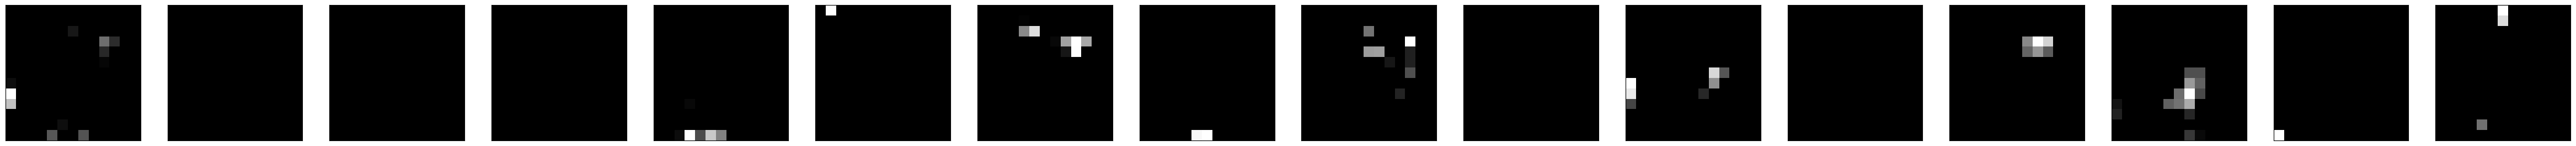

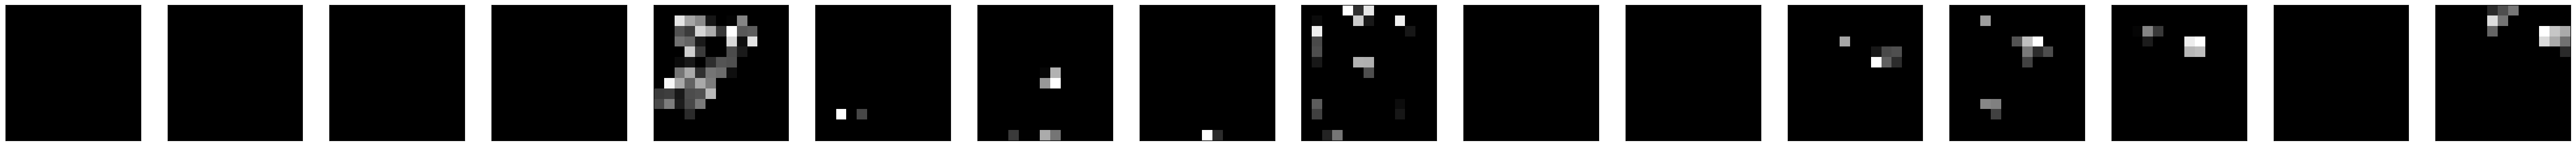

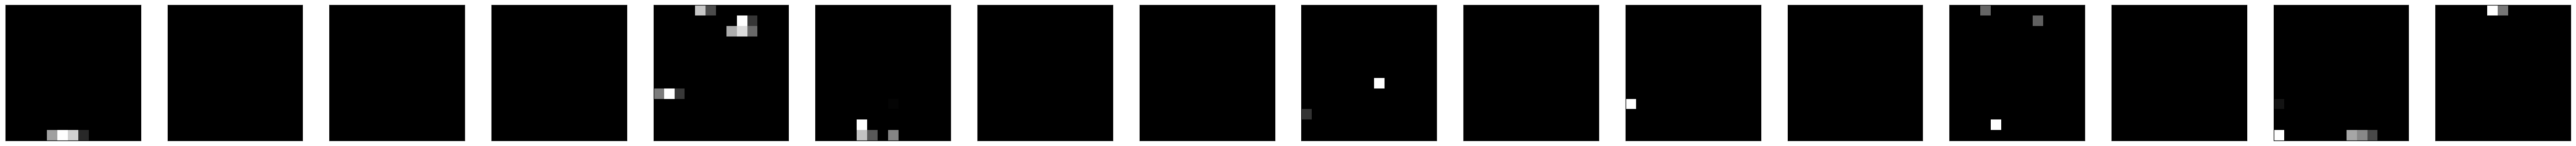

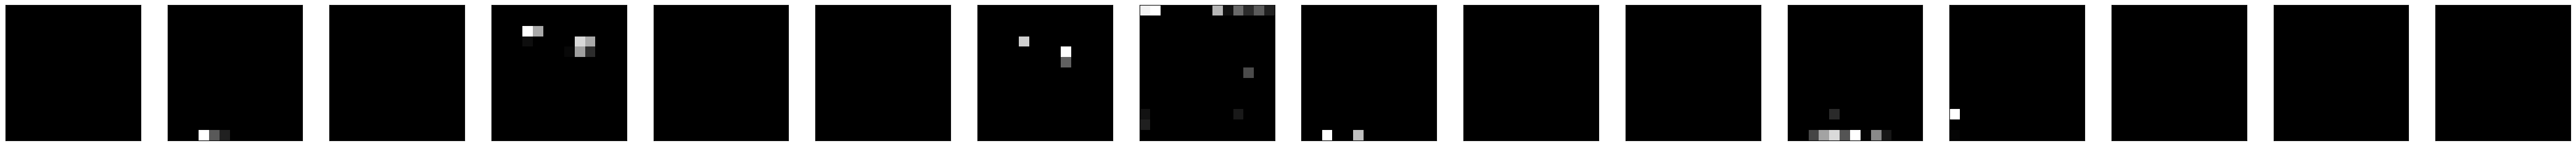

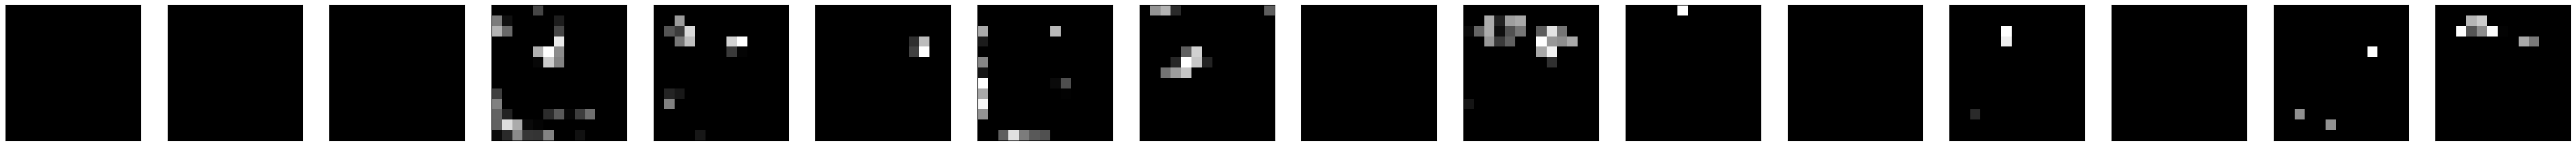

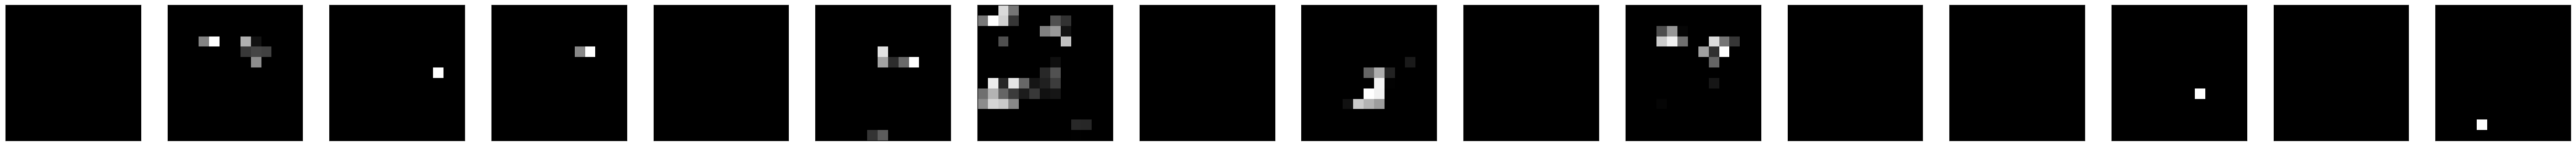

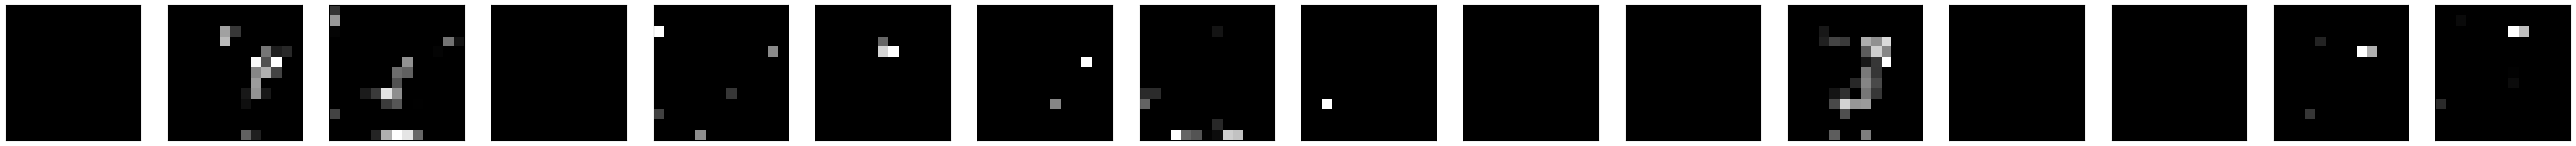

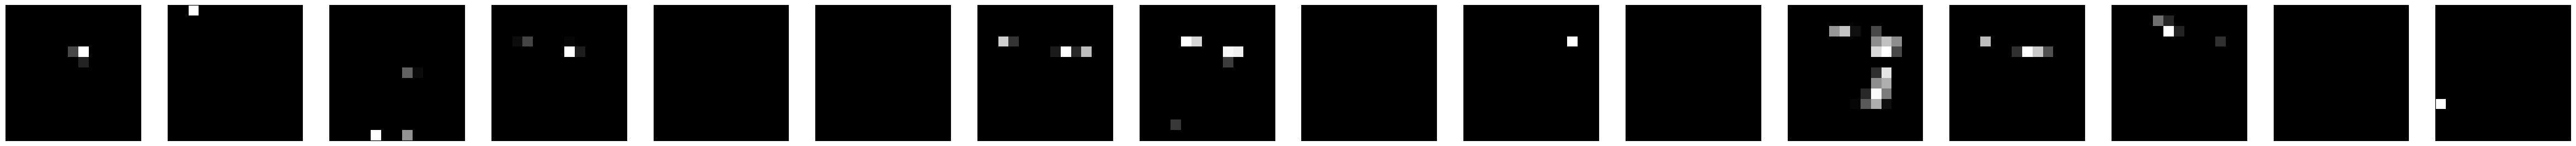

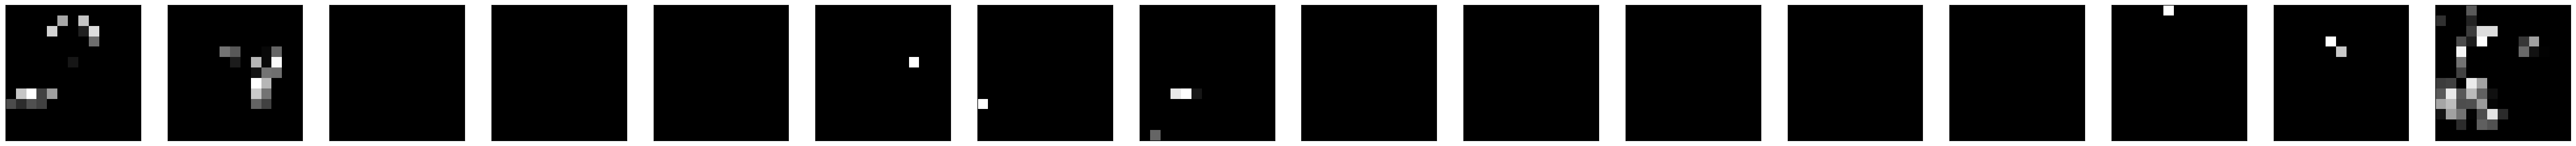

cam:


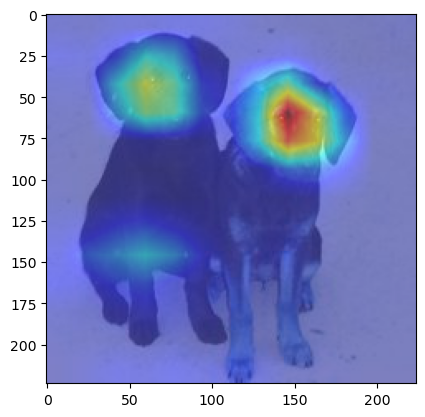

dog
activation map:


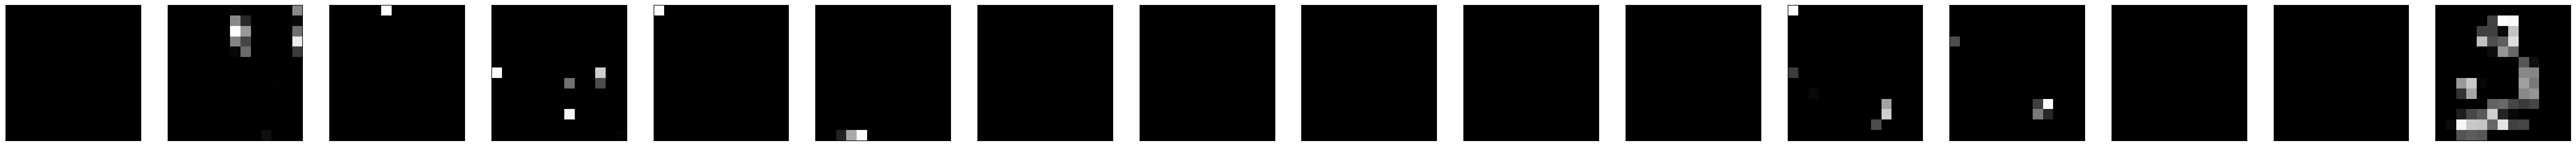

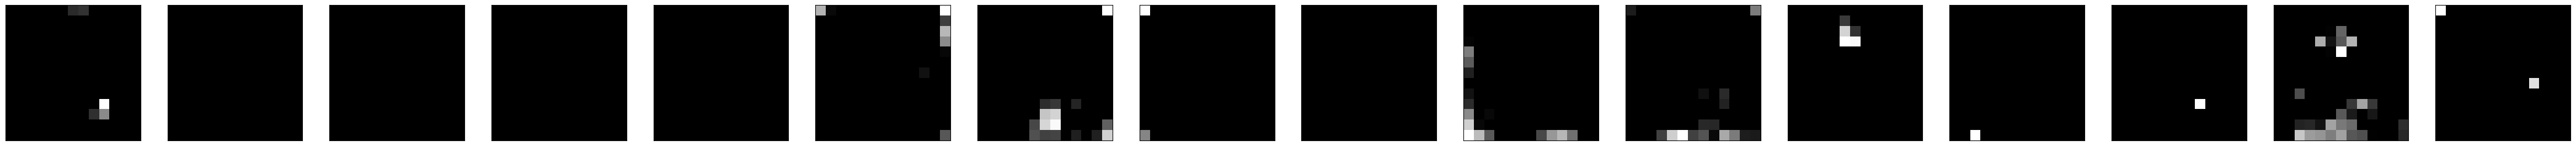

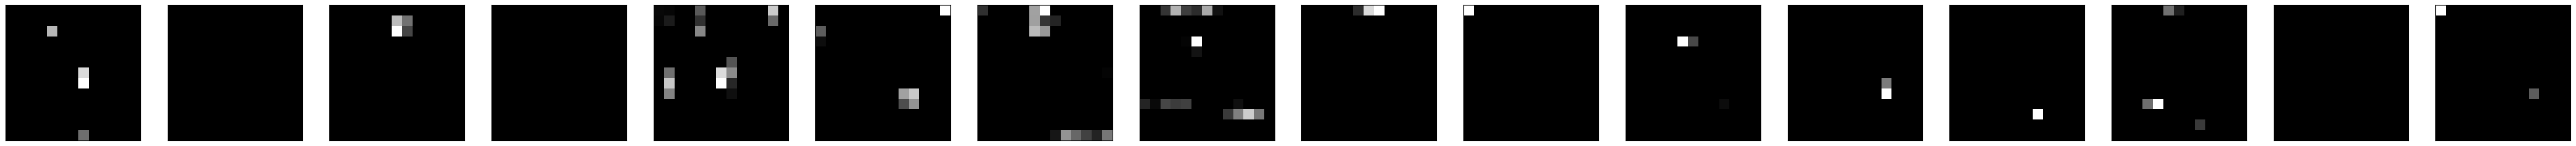

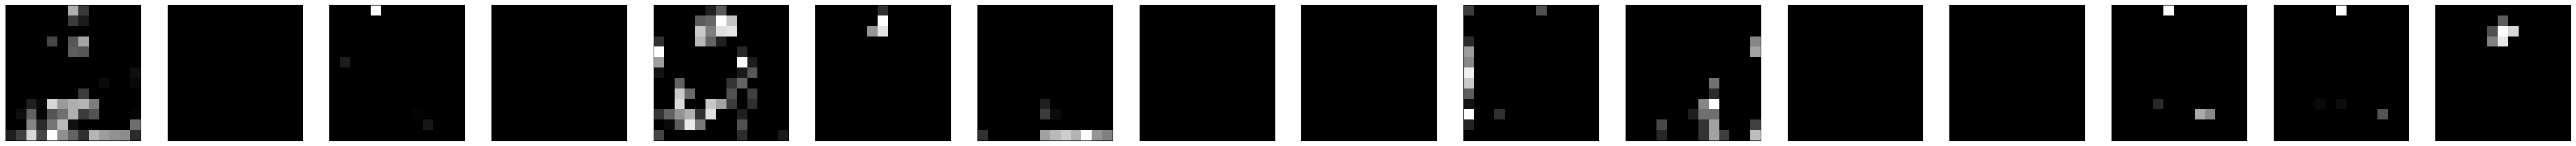

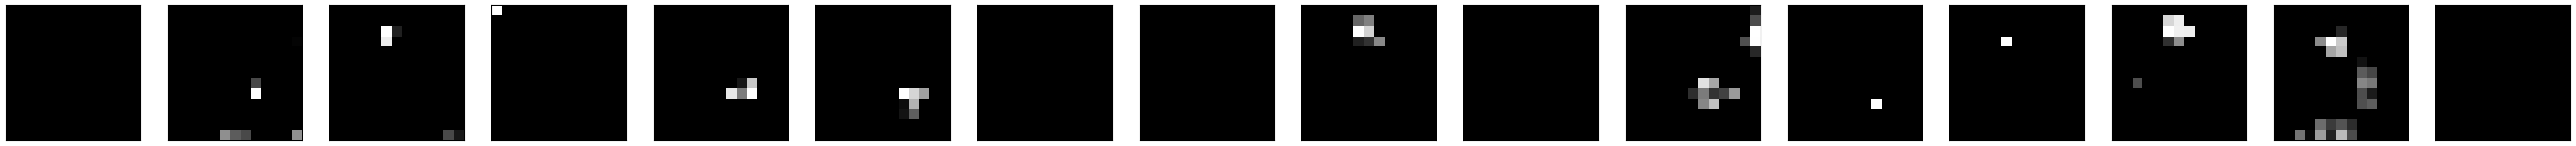

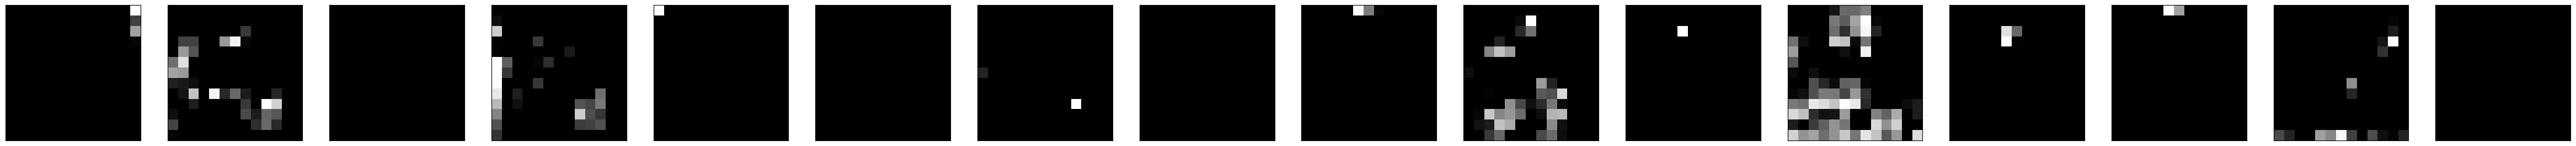

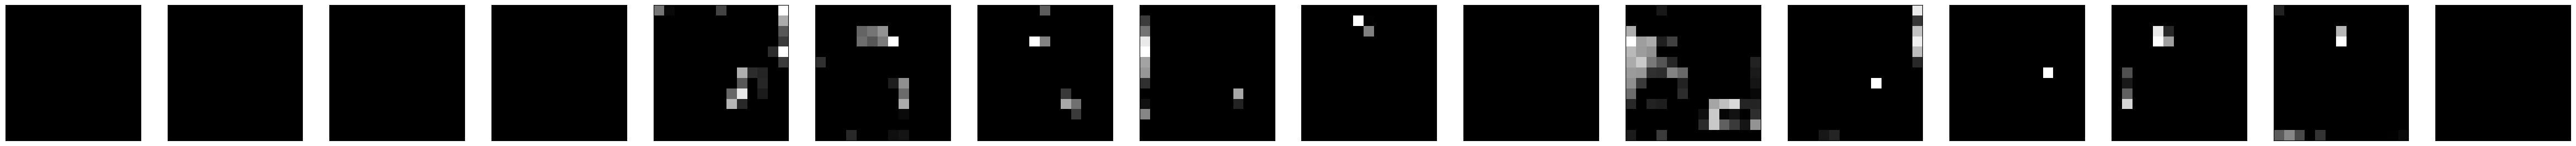

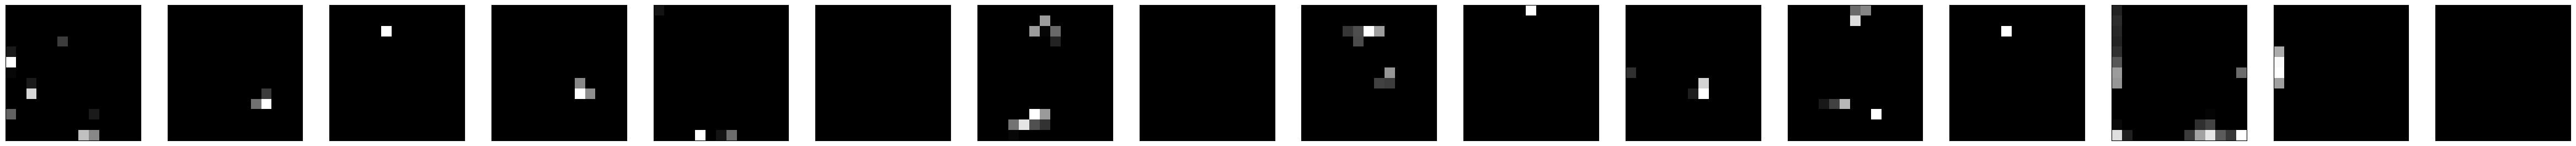

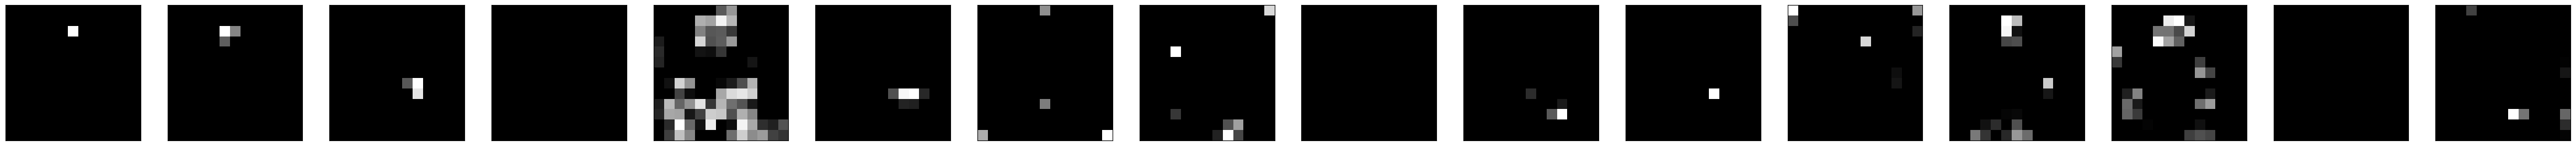

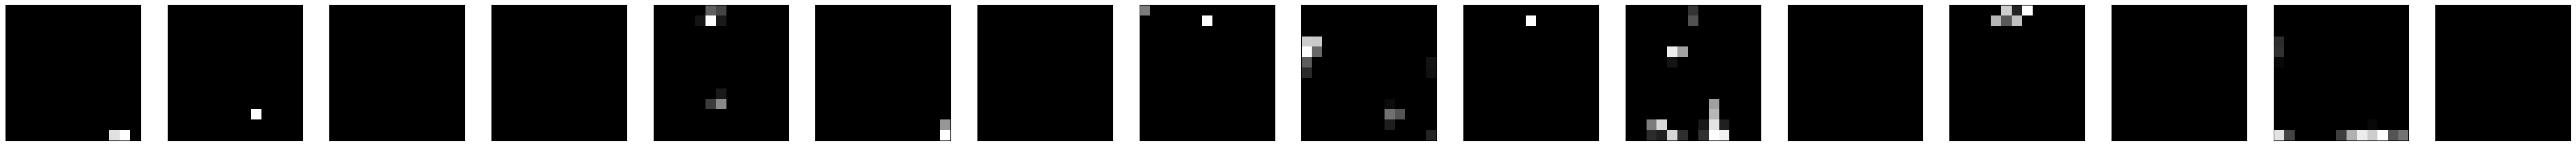

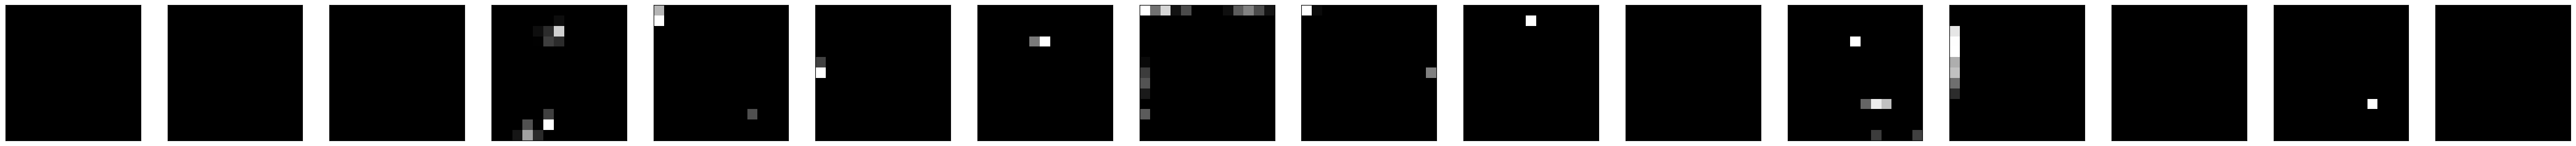

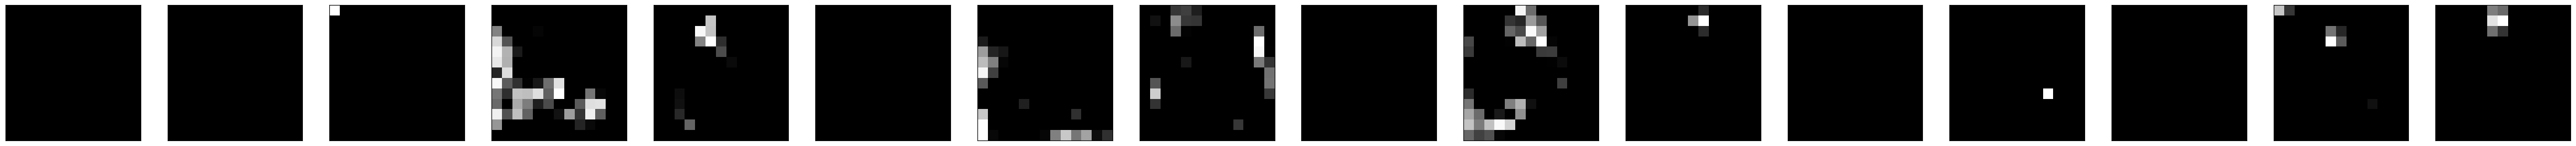

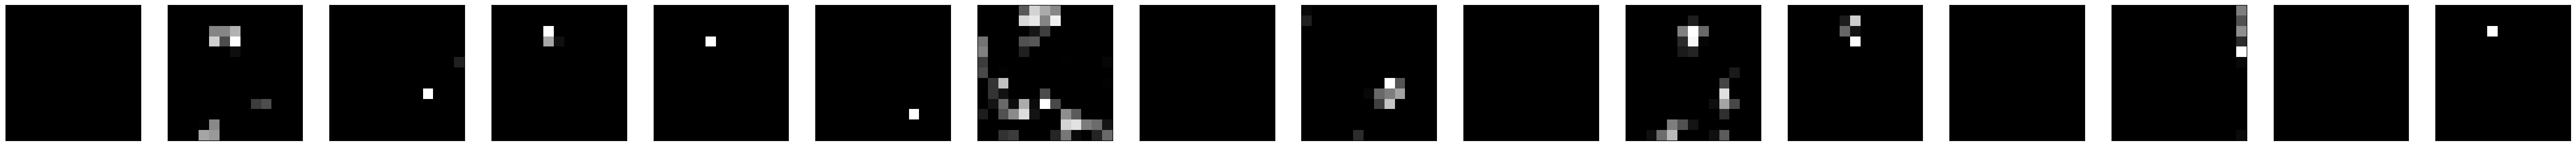

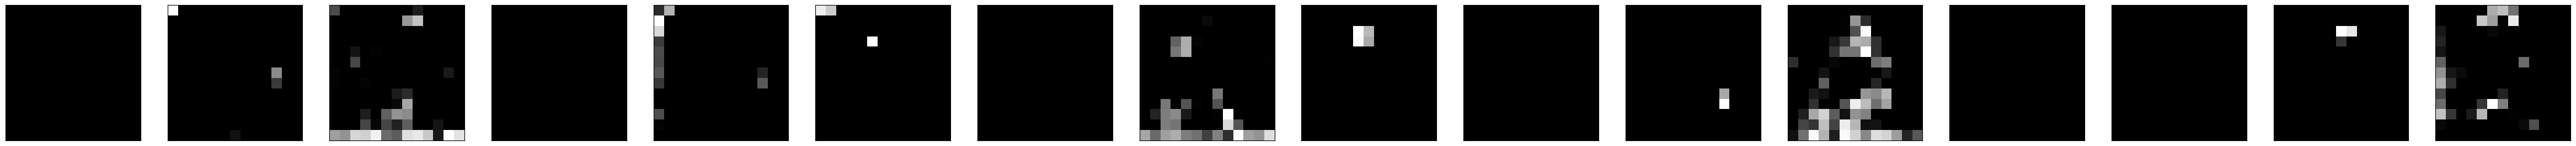

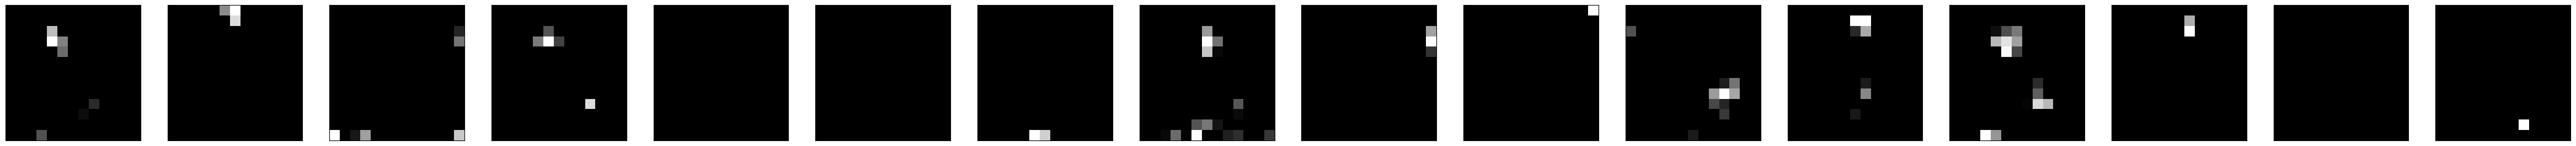

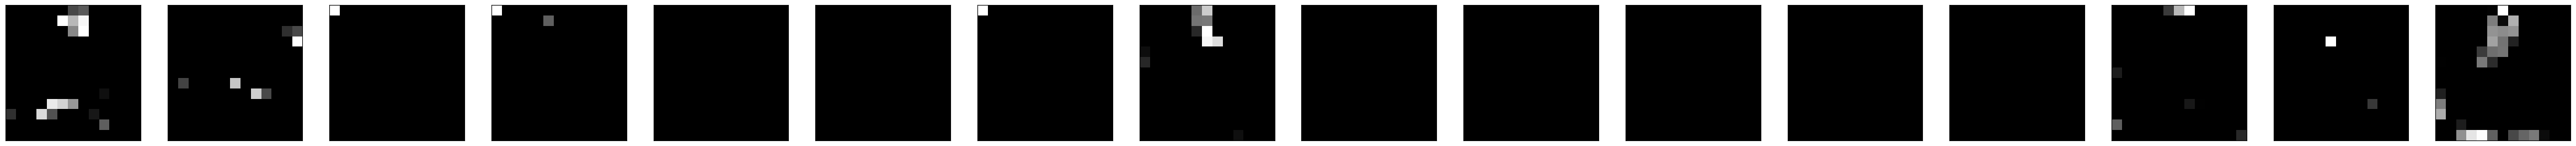

cam:


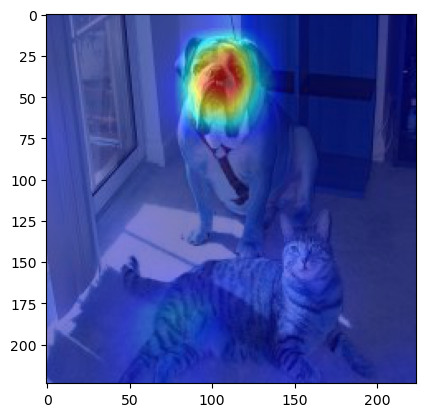

In [2]:
import torch
import torchvision.transforms as transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchview import draw_graph


def cam_show_img(img, activation, grads, W, H):
    print("activation map:")
    for i in range(activation.shape[0] // 16):
        plt.figure(figsize=(60, 4))
        for j in range(0, 16):
            ax = plt.subplot(1, 16, j + 1)
            ax.set_xticks([])
            ax.set_yticks([])
            activation_vis = np.uint8(255 * activation[i * 16 + j])
            plt.imshow(np.uint8(activation_vis), cmap='gray')
        plt.show()


    print("cam:")
    cam = np.zeros(activation.shape[1: ], dtype=np.float32)
    grads = grads.reshape([grads.shape[0], -1])
    weights = np.mean(grads, axis=1)	
    # print(weights.shape)
    # print(activation.shape)
    for i, w in enumerate(weights):
        cam += w * activation[i, :, :]
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    # print(cam.shape)
    cam = cv2.resize(cam, (W, H))

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    cam_img = 0.5 * heatmap + 0.5 * img

    plt.imshow(np.uint8(cam_img))
    plt.show()


for path in ["cat.jpg", "dog.jpg", "both.jpg"]:
    raw_img = cv2.imread("lab4_model_and_test_img/data4/" + path)
    preprocess = transforms.ToTensor()
    img = preprocess(raw_img)
    img = img.unsqueeze(0)
    (_, channel, W, H)=img.size()

    model = torch.load("lab4_model_and_test_img/" + 'torch_alex.pth')
    # model_graph = draw_graph(model, input_data=img, expand_nested=True, save_graph=True, filename="model")
    # model_graph.visual_graph

    gradients = []
    activations = []

    def backward_hook(module, grad_in, grad_out):
        def hook(grad):
            gradients.append(grad_out[0].detach())
        grad_out.register_hook(hook)
        

    def forward_hook(module, input, output):
        activations.append(output)


    model.features[10].register_forward_hook(forward_hook)
    model.features[10].register_forward_hook(backward_hook)


    # forward
    img = img.cuda()
    model = model.cuda()
    output = model(img)
    max_idx = np.argmax(output.data.cpu().numpy())
    print("cat" if max_idx == 0 else "dog")

    # backward
    model.zero_grad()
    class_loss = output[0, max_idx]	
    class_loss.backward()

    # grads
    grads_val = gradients[0].data.cpu().numpy().squeeze()
    activation = activations[0].data.cpu().numpy().squeeze()

    # show cam
    cam_show_img(raw_img, activation, grads_val, W, H)

